In [1]:
import pandas as pd
import cv2
import numpy as np
from datetime import datetime
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Flatten, Concatenate, TimeDistributed, Bidirectional   
from tensorflow.keras.applications import VGG16
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import optuna
import os
import tensorflow as tf
from tensorflow.keras.layers import PReLU
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D

2024-12-01 00:29:50.121956: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-01 00:29:50.122360: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-01 00:29:50.124248: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-01 00:29:50.129333: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-01 00:29:50.137580: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:

# Funciones
# Función para convertir el formato de timestamp del DataFrame al formato de los nombres de las imágenes
def get_closest_image_path(timestamp, image_folder):
    base_image_name = f'OR_ABI-L2-ACMF-M6_G16_s{timestamp.strftime("%Y%m%d%H%M")}'
    for second in range(60):
        image_name = f"{base_image_name}{second:02d}.png"
        image_path = os.path.join(image_folder, image_name)
        if os.path.exists(image_path):
            return image_path
    return None



def calculate_fourier_features(series, n_components=5):
    fft = np.fft.fft(series)
    fft_magnitudes = np.abs(fft)[:len(fft) // 2]  # Usar solo frecuencias positivas
    top_frequencies = np.argsort(fft_magnitudes)[-n_components:]  # Seleccionar las más importantes
    top_magnitudes = fft_magnitudes[top_frequencies]
    
    # Asegurarse de que `top_magnitudes` siempre tenga longitud `n_components`
    if len(top_magnitudes) < n_components:
        # Si hay menos componentes, rellenar con ceros
        padding = np.zeros(n_components - len(top_magnitudes))
        top_magnitudes = np.concatenate([top_magnitudes, padding])
    
    return top_magnitudes


def load_images_and_ghi(df_filtrado, image_folder, n_fourier=5):
    images = []
    ghi_values = []
    doy_sin = []
    doy_cos = []
    hour_sin = []
    hour_cos = []
    fourier_features = []

    # Inicializar la última imagen válida con una imagen de ceros por si es la primera vez
    last_valid_image = np.zeros((64, 64, 3), dtype=np.uint8)

    for idx, row in df_filtrado.iterrows():
        timestamp = row['Timestamp']
        ghi_value = row['GHI']
        doy_sin_value = row['DoY Sin']
        doy_cos_value = row['DoY Cos']

        # Calcular seno y coseno de la hora del día
        hour_fraction = timestamp.hour + timestamp.minute / 60.0
        hour_sin_value = np.sin(2 * np.pi * hour_fraction / 24)
        hour_cos_value = np.cos(2 * np.pi * hour_fraction / 24)

        image_path = get_closest_image_path(timestamp, image_folder)
        img = cv2.imread(image_path)

        if img is not None:
            # Procesar la imagen si está disponible
            img_resized = cv2.resize(img, (64, 64))
            img_preprocessed = tf.keras.applications.vgg16.preprocess_input(img_resized)
            last_valid_image = img_preprocessed  # Actualizar la última imagen válida
        else:
            # Usar la última imagen válida (Forward Fill)
            img_preprocessed = last_valid_image
            print(f"Imagen no encontrada: {image_path}, usando la última imagen válida.")

        # Agregar valores a las listas
        images.append(img_preprocessed)
        ghi_values.append(ghi_value)
        doy_sin.append(doy_sin_value)
        doy_cos.append(doy_cos_value)
        hour_sin.append(hour_sin_value)
        hour_cos.append(hour_cos_value)

        # Calcular componentes de Fourier para GHI
        if len(ghi_values) >= n_fourier:
            fourier_comp = calculate_fourier_features(ghi_values[-n_fourier:], n_components=n_fourier)
        else:
            fourier_comp = np.zeros(n_fourier)  # Rellenar con ceros si no hay suficientes datos

        fourier_features.append(fourier_comp)

    # Convertir a numpy arrays, asegurando consistencia en las dimensiones
    ghi_values = np.array(ghi_values).reshape(-1, 1)
    scaler = MinMaxScaler()
    ghi_values_scaled = scaler.fit_transform(ghi_values)

    doy_sin = np.array(doy_sin).reshape(-1, 1)
    doy_cos = np.array(doy_cos).reshape(-1, 1)
    hour_sin = np.array(hour_sin).reshape(-1, 1)
    hour_cos = np.array(hour_cos).reshape(-1, 1)

    print(f"doy_sin_train shape: {doy_sin.shape}")
    print(f"doy_cos_train shape: {doy_cos.shape}")
    print(f"hour_sin_train shape: {hour_sin.shape}")
    print(f"hour_cos_train shape: {hour_cos.shape}")
    print(f"fourier_features_train shape: {len(fourier_features)}")
    # Convertir fourier_features en numpy array de forma consistente
    fourier_features = np.array(fourier_features)

    return np.array(images), ghi_values_scaled, scaler, doy_sin, doy_cos, hour_sin, hour_cos, fourier_features


# Preparar secuencias para la LSTM
def create_sequences(images, aux_features, ghi_values, time_steps):
    X_images_seq = []
    X_aux_seq = []
    y_seq = []

    for i in range(len(images) - time_steps):
        # Crear secuencia de imágenes de longitud `time_steps`
        X_images_seq.append(images[i:i + time_steps])
        
        # Crear secuencia de características auxiliares de longitud `time_steps`
        X_aux_seq.append(aux_features[i:i + time_steps])
        
        # La variable objetivo es una secuencia de `n_steps` valores GHI después del último paso de la secuencia
        y_seq.append(ghi_values[i + time_steps])

    return np.array(X_images_seq), np.array(X_aux_seq), np.array(y_seq)



In [3]:

# Funciones
# Función para convertir el formato de timestamp del DataFrame al formato de los nombres de las imágenes
def get_closest_image_path(timestamp, image_folder):
    base_image_name = f'OR_ABI-L2-ACMF-M6_G16_s{timestamp.strftime("%Y%m%d%H%M")}'
    for second in range(60):
        image_name = f"{base_image_name}{second:02d}.png"
        image_path = os.path.join(image_folder, image_name)
        if os.path.exists(image_path):
            return image_path
    return None



def calculate_fourier_features(series, n_components=5):
    fft = np.fft.fft(series)
    fft_magnitudes = np.abs(fft)[:len(fft) // 2]  # Usar solo frecuencias positivas
    top_frequencies = np.argsort(fft_magnitudes)[-n_components:]  # Seleccionar las más importantes
    top_magnitudes = fft_magnitudes[top_frequencies]
    
    # Asegurarse de que `top_magnitudes` siempre tenga longitud `n_components`
    if len(top_magnitudes) < n_components:
        # Si hay menos componentes, rellenar con ceros
        padding = np.zeros(n_components - len(top_magnitudes))
        top_magnitudes = np.concatenate([top_magnitudes, padding])
    
    return top_magnitudes


def load_images_and_ghi(df_filtrado, image_folder, n_fourier=5):
    images = []
    ghi_values = []
    doy_sin = []
    doy_cos = []
    hour_sin = []
    hour_cos = []
    fourier_features = []

    # Inicializar la última imagen válida con una imagen de ceros por si es la primera vez
    last_valid_image = np.zeros((64, 64, 3), dtype=np.uint8)

    for idx, row in df_filtrado.iterrows():
        timestamp = row['Timestamp']
        ghi_value = row['GHI']
        doy_sin_value = row['DoY Sin']
        doy_cos_value = row['DoY Cos']

        # Calcular seno y coseno de la hora del día
        hour_fraction = timestamp.hour + timestamp.minute / 60.0
        hour_sin_value = np.sin(2 * np.pi * hour_fraction / 24)
        hour_cos_value = np.cos(2 * np.pi * hour_fraction / 24)

        image_path = get_closest_image_path(timestamp, image_folder)
        img = cv2.imread(image_path)

        if img is not None:
            # Procesar la imagen si está disponible
            img_resized = cv2.resize(img, (64, 64))
            img_preprocessed = tf.keras.applications.vgg16.preprocess_input(img_resized)
            last_valid_image = img_preprocessed  # Actualizar la última imagen válida
        else:
            # Usar la última imagen válida (Forward Fill)
            img_preprocessed = last_valid_image
            print(f"Imagen no encontrada: {image_path}, usando la última imagen válida.")

        # Agregar valores a las listas
        images.append(img_preprocessed)
        ghi_values.append(ghi_value)
        doy_sin.append(doy_sin_value)
        doy_cos.append(doy_cos_value)
        hour_sin.append(hour_sin_value)
        hour_cos.append(hour_cos_value)

        # Calcular componentes de Fourier para GHI
        if len(ghi_values) >= n_fourier:
            fourier_comp = calculate_fourier_features(ghi_values[-n_fourier:], n_components=n_fourier)
        else:
            fourier_comp = np.zeros(n_fourier)  # Rellenar con ceros si no hay suficientes datos

        fourier_features.append(fourier_comp)

    # Convertir a numpy arrays, asegurando consistencia en las dimensiones
    ghi_values = np.array(ghi_values).reshape(-1, 1)
    scaler = MinMaxScaler()
    ghi_values_scaled = scaler.fit_transform(ghi_values)

    doy_sin = np.array(doy_sin).reshape(-1, 1)
    doy_cos = np.array(doy_cos).reshape(-1, 1)
    hour_sin = np.array(hour_sin).reshape(-1, 1)
    hour_cos = np.array(hour_cos).reshape(-1, 1)

    # Convertir fourier_features en numpy array de forma consistente
    fourier_features = np.array(fourier_features)

    return np.array(images), ghi_values_scaled, scaler, doy_sin, doy_cos, hour_sin, hour_cos, fourier_features


# Preparar secuencias para la LSTM
def create_sequences(images, aux_features, ghi_values, time_steps):
    X_images_seq = []
    X_aux_seq = []
    y_seq = []

    for i in range(len(images) - time_steps):
        # Crear secuencia de imágenes de longitud `time_steps`
        X_images_seq.append(images[i:i + time_steps])
        
        # Crear secuencia de características auxiliares de longitud `time_steps`
        X_aux_seq.append(aux_features[i:i + time_steps])
        
        # La variable objetivo es una secuencia de `n_steps` valores GHI después del último paso de la secuencia
        y_seq.append(ghi_values[i + time_steps])

    return np.array(X_images_seq), np.array(X_aux_seq), np.array(y_seq)



In [4]:
# Construir modelo CNN-LSTM optimizado con Optuna
def build_model_with_optuna(trial, time_steps, aux_features_shape):
    # Hiperparámetros
    lstm_units_cnn = trial.suggest_int("lstm_units_cnn", 64, 256, step=64)
    lstm_units_aux = trial.suggest_int("lstm_units_aux", 32, 256, step=32)
    dense_units = trial.suggest_int("dense_units", 64, 300, step=64)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.6, step=0.1)
    optimizador = trial.suggest_categorical('optimizer', ['adam', 'RMSprop'])

    # Submodelo para imágenes (CNN con VGG16 preentrenado)
    vgg16 = VGG16(include_top=False, input_shape=(64, 64, 3))
    for layer in vgg16.layers[:15]:
        layer.trainable = False  # Congela las capas preentrenadas

    cnn_model = tf.keras.Sequential([
        vgg16,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(dropout_rate)
    ])

    image_input = Input(shape=(time_steps, 64, 64, 3))
    processed_images = TimeDistributed(cnn_model)(image_input)

    # Submodelo LSTM
    lstm_out = Bidirectional(LSTM(lstm_units_cnn, return_sequences=False))(processed_images)

    # Submodelo para características auxiliares
    aux_input = Input(shape=(time_steps, aux_features_shape))
    lstm_aux_out = LSTM(lstm_units_aux, return_sequences=False)(aux_input)

    # Combinar salidas de CNN-LSTM y LSTM auxiliar
    combined = Concatenate()([lstm_out, lstm_aux_out])

    # Capas densas finales
    dense_out = Dense(dense_units, activation='relu')(combined)
    dense_out = Dropout(dropout_rate)(dense_out)
    final_output = Dense(1, activation='linear')(dense_out)

    # Modelo completo
    model = Model(inputs=[image_input, aux_input], outputs=final_output)
    model.compile(optimizer=optimizador, loss='mse', metrics=['mae'])
    return model





In [5]:

df = pd.read_pickle('/home/aia-workstation/Documents/Santiago/Modelo/Cloud_Forecasting_CNN_LSTM/df_GHI.plk')

# Filtrar datos
fecha_inicio_entrenamiento = '2023-01-01 05:00:00'
fecha_fin_entrenamiento = '2023-02-28 18:30:00'

df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df_entrenamiento = df[(df['Timestamp'] >= fecha_inicio_entrenamiento) & (df['Timestamp'] <= fecha_fin_entrenamiento)]

image_folder = '/home/aia-workstation/Documents/Santiago/Modelo/Cloud_Forecasting_CNN_LSTM/Images/ACMF'
X_images_train, y_ghi_train, scaler_train, doy_sin_train, doy_cos_train,hour_sin_train,hour_cos_train, fourier_features_train = load_images_and_ghi(df_entrenamiento, image_folder)


    
X_aux_features_train = np.concatenate([doy_sin_train, doy_cos_train,hour_sin_train,hour_cos_train ,fourier_features_train], axis=1)
time_steps = 18
X_images_train_seq, X_aux_train_seq, y_train_seq = create_sequences(X_images_train, X_aux_features_train, y_ghi_train, time_steps)



Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@2.599] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@5.434] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@8.778] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@8.839] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@9.731] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@11.398] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@11.460] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


In [6]:

# Función objetivo para Optuna
def objective(trial):

    model = build_model_with_optuna(trial, time_steps, X_aux_features_train.shape[1])

    history = model.fit(
        [X_images_train_seq, X_aux_train_seq],
        y_train_seq,
        epochs=10,
        batch_size=32,
        validation_split=0.2,
        verbose=0
    )

    val_loss = history.history['val_loss'][-1]
    return val_loss

# Ejecución de Optuna
if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=20)
    print("Mejores hiperparámetros:", study.best_params)



[I 2024-12-01 00:30:03,952] A new study created in memory with name: no-name-a3b80c33-c045-4306-814f-65d529027ed1
/home/aia-workstation/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [64, 300] and step=64, but the range is not divisible by `step`. It will be replaced by [64, 256].
  warnings.warn(
I0000 00:00:1733031003.960029 1956477 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-01 00:30:03.960276: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libra

Mejores hiperparámetros: {'lstm_units_cnn': 192, 'lstm_units_aux': 64, 'dense_units': 64, 'dropout_rate': 0.2, 'optimizer': 'adam'}


In [12]:
model.save('/home/aia-workstation/Documents/Juan F/M-1/Modelo final lluvias.h5')

# Submodelo para imágenes (CNN con VGG16 preentrenado)
# vgg16 = VGG16(include_top=False, input_shape=(64, 64, 3))
# for layer in vgg16.layers[:15]:
#     layer.trainable = False  # Congela las capas preentrenadas

# cnn_model = tf.keras.Sequential([
#     vgg16,
#     GlobalAveragePooling2D(),
#     Dense(128, activation='relu'),
#     Dropout(0.4)
#     ])

# image_input = Input(shape=(time_steps, 64, 64, 3))
# processed_images = TimeDistributed(cnn_model)(image_input)

# # Submodelo LSTM
# lstm_out = LSTM(128, return_sequences=False)(processed_images)

# # Submodelo para características auxiliares
# aux_input = Input(shape=(time_steps, X_aux_features_train.shape[1]))
# lstm_aux_out = LSTM(64, return_sequences=False)(aux_input)

# # Combinar salidas de CNN-LSTM y LSTM auxiliar
# combined = Concatenate()([lstm_out, lstm_aux_out])

# # Capas densas finales
# dense_out = Dense(256, activation='relu')(combined)
# dense_out = Dropout(0.2)(dense_out)
# final_output = Dense(1, activation='linear')(dense_out)

# # Modelo completo
# model = Model(inputs=[image_input, aux_input], outputs=final_output)
# model.compile(optimizer='RMSprop', loss='mse', metrics=['mae'])


# # Entrenamiento del modelo final
# model.fit([X_images_train_seq, X_aux_train_seq], y_train_seq, epochs=200, batch_size=16, validation_split=0.2,
#           callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
#                      ReduceLROnPlateau(monitor='val_loss', factor=0.005, patience=5, min_lr=1e-6)])

In [8]:


# Submodelo para imágenes (CNN con VGG16 preentrenado)
vgg16 = VGG16(include_top=False, input_shape=(64, 64, 3))
for layer in vgg16.layers[:15]:
    layer.trainable = False  # Congela las capas preentrenadas

cnn_model = tf.keras.Sequential([
    vgg16,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(study.best_params['dropout_rate'])
    ])

image_input = Input(shape=(time_steps, 64, 64, 3))
processed_images = TimeDistributed(cnn_model)(image_input)

# Submodelo LSTM
lstm_out = LSTM(study.best_params['lstm_units_cnn'], return_sequences=False)(processed_images)

# Submodelo para características auxiliares
aux_input = Input(shape=(time_steps, X_aux_features_train.shape[1]))
lstm_aux_out = LSTM(study.best_params['lstm_units_aux'], return_sequences=False)(aux_input)

# Combinar salidas de CNN-LSTM y LSTM auxiliar
combined = Concatenate()([lstm_out, lstm_aux_out])

# Capas densas finales
dense_out = Dense(study.best_params['dense_units'], activation='relu')(combined)
dense_out = Dropout(study.best_params['dropout_rate'])(dense_out)
final_output = Dense(1, activation='linear')(dense_out)

# Modelo completo
model = Model(inputs=[image_input, aux_input], outputs=final_output)
model.compile(optimizer=study.best_params['optimizer'], loss='mse', metrics=['mae'])

#entrenamiento modelo final
model.fit([X_images_train_seq, X_aux_train_seq], y_train_seq, epochs=200, batch_size=16, validation_split=0.2,
          callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
                     ReduceLROnPlateau(monitor='val_loss', factor=0.005, patience=5, min_lr=1e-6)])

Epoch 1/200


/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_724', 'keras_tensor_729']. Received: the structure of inputs=('*', '*')
  warnings.warn(


241/241 ━━━━━━━━━━━━━━━━━━━━ 169s 684ms/step - loss: 0.1064 - mae: 0.2380 - val_loss: 0.0071 - val_mae: 0.0549 - learning_rate: 0.0010
Epoch 2/200
241/241 ━━━━━━━━━━━━━━━━━━━━ 165s 686ms/step - loss: 0.0143 - mae: 0.0871 - val_loss: 0.0047 - val_mae: 0.0366 - learning_rate: 0.0010
Epoch 3/200
241/241 ━━━━━━━━━━━━━━━━━━━━ 165s 684ms/step - loss: 0.0099 - mae: 0.0699 - val_loss: 0.0114 - val_mae: 0.0806 - learning_rate: 0.0010
Epoch 4/200
241/241 ━━━━━━━━━━━━━━━━━━━━ 160s 666ms/step - loss: 0.0079 - mae: 0.0621 - val_loss: 0.0053 - val_mae: 0.0387 - learning_rate: 0.0010
Epoch 5/200
241/241 ━━━━━━━━━━━━━━━━━━━━ 161s 667ms/step - loss: 0.0078 - mae: 0.0615 - val_loss: 0.0058 - val_mae: 0.0400 - learning_rate: 0.0010
Epoch 6/200
241/241 ━━━━━━━━━━━━━━━━━━━━ 161s 667ms/step - loss: 0.0076 - mae: 0.0601 - val_loss: 0.0054 - val_mae: 0.0392 - learning_rate: 0.0010
Epoch 7/200
241/241 ━━━━━━━━━━━━━━━━━━━━ 161s 667ms/step - loss: 0.0066 - mae: 0.0575 - val_loss: 0.0053 - val_mae: 0.0379 - learn

Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@36079.031] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@36079.134] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@36079.194] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@36079.207] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@36079.531] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@36079.714] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@36080.077] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@36080.077] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@36080.078] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@36080.078] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@36080.078] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 797ms/step
MAE en el conjunto de prueba: 0.12023898786904014
RMSE en el conjunto de prueba: 0.16117644222302333


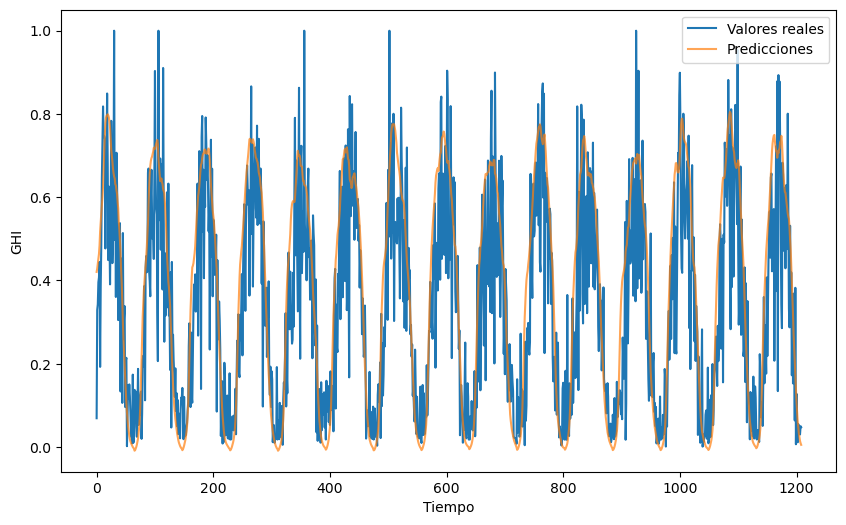

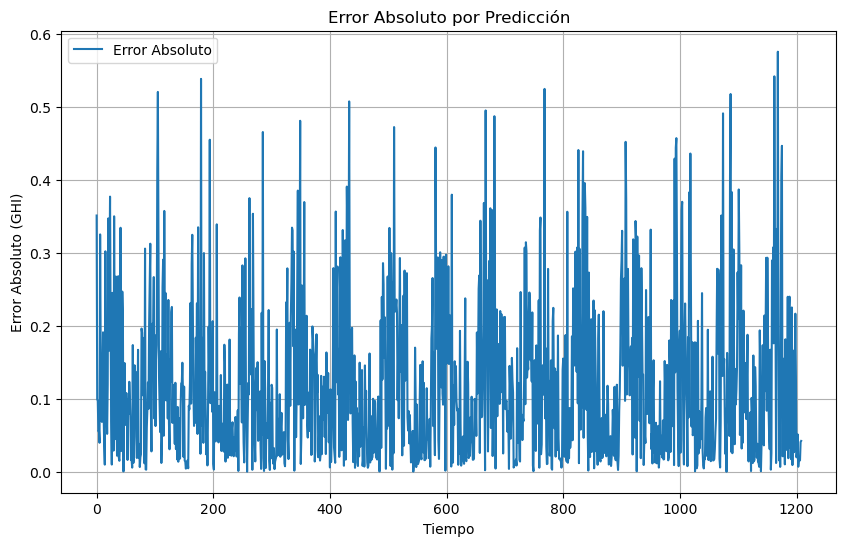

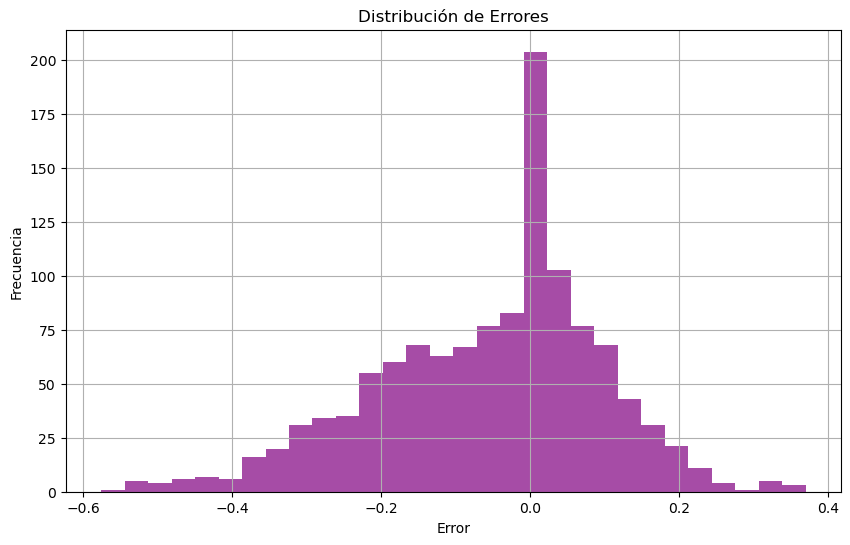

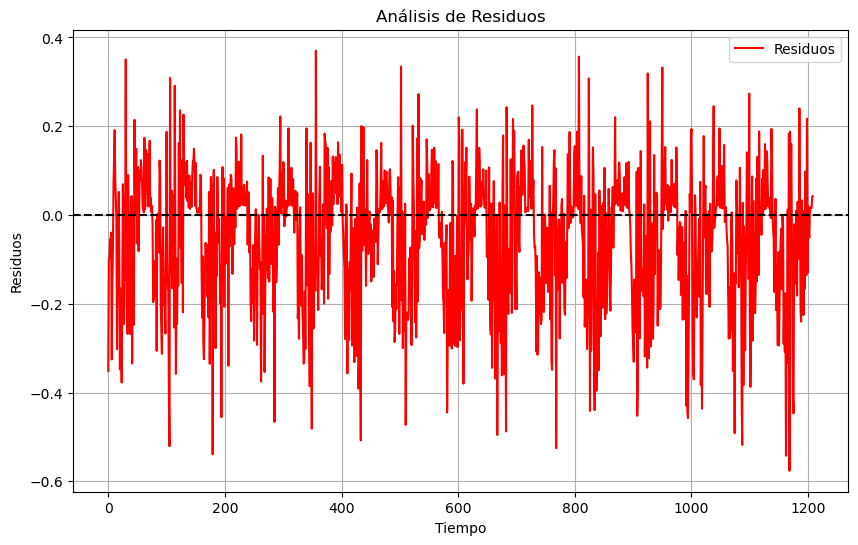

In [17]:
# Probar el modelo
# Preparar el conjunto de prueba (días nubosos)
fecha_inicio_prueba = '2023-03-1 05:00:00'  # Fecha de inicio de prueba
fecha_fin_prueba = '2023-03-15 18:00:00'  # Fecha de fin de prueba

# Filtrar el DataFrame por el rango de prueba
df_prueba = df[(df['Timestamp'] >= fecha_inicio_prueba) & (df['Timestamp'] <= fecha_fin_prueba)]

# Cargar imágenes y valores GHI para el conjunto de prueba
X_images_test, y_ghi_test, scaler_test, doy_sin_test, doy_cos_test, hour_sin_train,hour_cos_train, fourier_features_train = load_images_and_ghi(df_prueba, image_folder)

# Concatenar DOY sin y cos con las imágenes de prueba
X_aux_features_test = np.concatenate([doy_sin_test, doy_cos_test,hour_sin_train,hour_cos_train,fourier_features_train], axis=1)

# Crear las secuencias de prueba con time_steps 
X_images_test_seq, X_aux_test_seq, y_test_seq = create_sequences(X_images_test, X_aux_features_test, y_ghi_test, time_steps)

# Hacer predicciones
y_pred = model.predict([X_images_test_seq, X_aux_test_seq])

# Invertir la normalización para GHI
y_test_seq_inversed = scaler_test.inverse_transform(y_test_seq)
y_pred_inversed = scaler_test.inverse_transform(y_pred)

# Evaluar el modelo
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test_seq_inversed, y_pred_inversed)
rmse = np.sqrt(mean_squared_error(y_test_seq_inversed, y_pred_inversed))

print(f'MAE en el conjunto de prueba: {mae}')
print(f'RMSE en el conjunto de prueba: {rmse}')

# Visualizar algunas predicciones
plt.figure(figsize=(10, 6))
plt.plot(y_test_seq_inversed, label='Valores reales')
plt.plot(y_pred_inversed, label='Predicciones', alpha=0.7)
plt.xlabel('Tiempo')
plt.ylabel('GHI')
plt.legend()
plt.show()

error_absoluto = np.abs(y_test_seq_inversed - y_pred_inversed)
plt.figure(figsize=(10, 6))
plt.plot(error_absoluto, label='Error Absoluto')
plt.xlabel('Tiempo')
plt.ylabel('Error Absoluto (GHI)')
plt.title('Error Absoluto por Predicción')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(y_test_seq_inversed - y_pred_inversed, bins=30, alpha=0.7, color='purple')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.title('Distribución de Errores')
plt.grid()
plt.show()

residuos = y_test_seq_inversed - y_pred_inversed
plt.figure(figsize=(10, 6))
plt.plot(residuos, label='Residuos', color='red')
plt.xlabel('Tiempo')
plt.ylabel('Residuos')
plt.title('Análisis de Residuos')
plt.axhline(y=0, color='black', linestyle='--')
plt.legend()
plt.grid()
plt.show()

Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@36112.773] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@36113.325] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@36113.326] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la úl

[ WARN:0@36114.142] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@36114.143] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@36114.143] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@36114.143] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@36114.143] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@36114.143] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@36114.143] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@36114.143] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@36114.143] global loadsave.cpp:241 findDecoder imread_(

Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@36115.277] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 790ms/step
MAE en el conjunto de prueba: 0.12374502515013205
RMSE en el conjunto de prueba: 0.1650285676032736


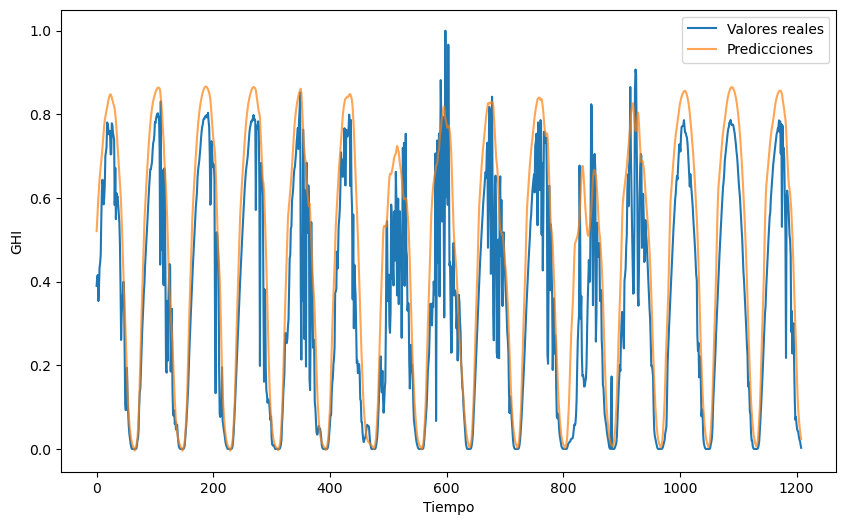

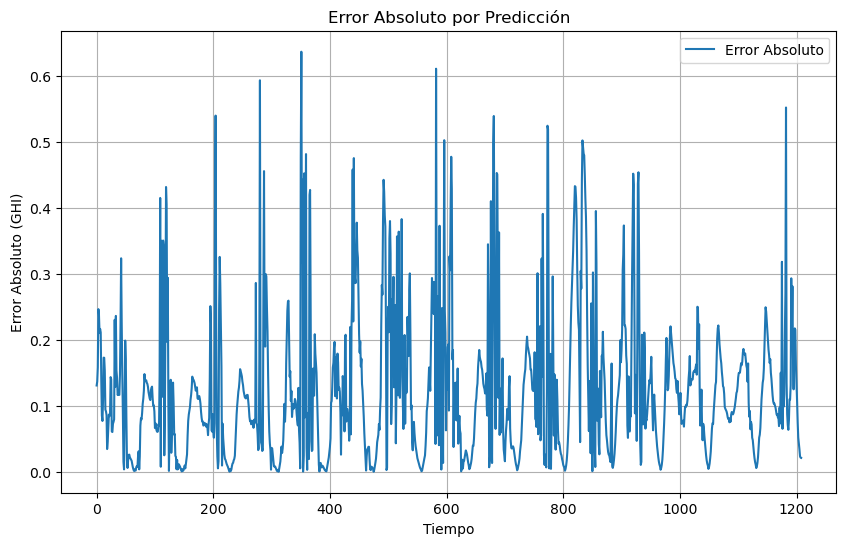

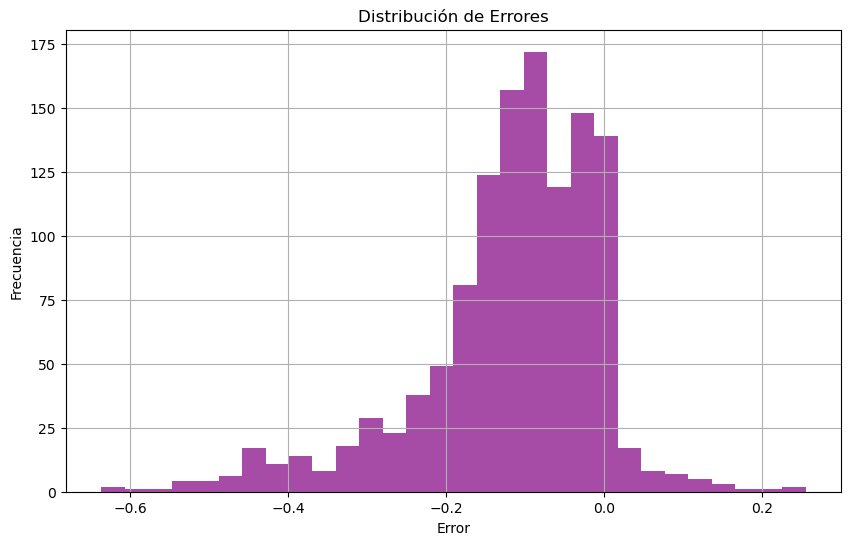

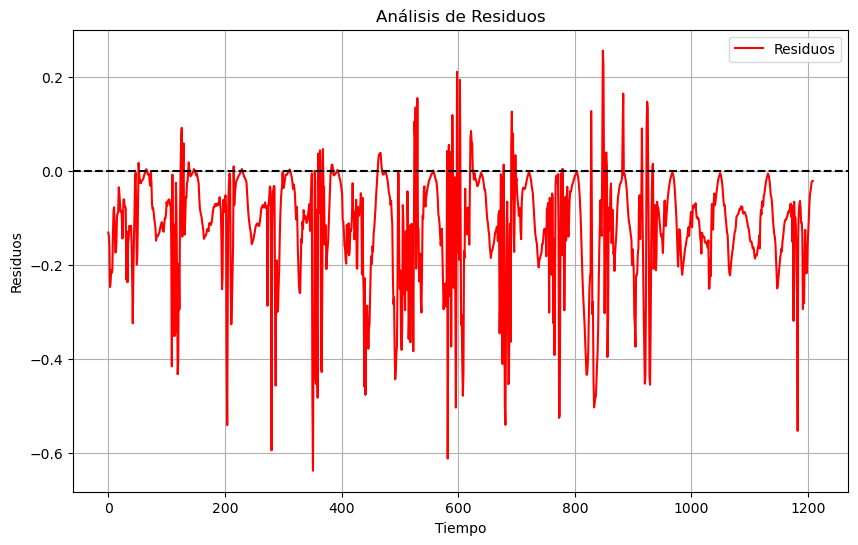

In [18]:
# Probar el modelo
# Preparar el conjunto de prueba (días no nubosos)
fecha_inicio_prueba = '2023-04-1 05:00:00'  # Fecha de inicio de prueba
fecha_fin_prueba = '2023-04-15 18:00:00'  # Fecha de fin de prueba

# Filtrar el DataFrame por el rango de prueba
df_prueba = df[(df['Timestamp'] >= fecha_inicio_prueba) & (df['Timestamp'] <= fecha_fin_prueba)]

# Cargar imágenes y valores GHI para el conjunto de prueba
X_images_test, y_ghi_test, scaler_test, doy_sin_test, doy_cos_test, hour_sin_train,hour_cos_train, fourier_features_train = load_images_and_ghi(df_prueba, image_folder)

# Concatenar DOY sin y cos con las imágenes de prueba
X_aux_features_test = np.concatenate([doy_sin_test, doy_cos_test,hour_sin_train,hour_cos_train,fourier_features_train], axis=1)

# Crear las secuencias de prueba con time_steps 
X_images_test_seq, X_aux_test_seq, y_test_seq = create_sequences(X_images_test, X_aux_features_test, y_ghi_test, time_steps)

# Hacer predicciones
y_pred = model.predict([X_images_test_seq, X_aux_test_seq])

# Invertir la normalización para GHI
y_test_seq_inversed = scaler_test.inverse_transform(y_test_seq)
y_pred_inversed = scaler_test.inverse_transform(y_pred)

# Evaluar el modelo
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test_seq_inversed, y_pred_inversed)
rmse = np.sqrt(mean_squared_error(y_test_seq_inversed, y_pred_inversed))

print(f'MAE en el conjunto de prueba: {mae}')
print(f'RMSE en el conjunto de prueba: {rmse}')

# Visualizar algunas predicciones
plt.figure(figsize=(10, 6))
plt.plot(y_test_seq_inversed, label='Valores reales')
plt.plot(y_pred_inversed, label='Predicciones', alpha=0.7)
plt.xlabel('Tiempo')
plt.ylabel('GHI')
plt.legend()
plt.show()

error_absoluto = np.abs(y_test_seq_inversed - y_pred_inversed)
plt.figure(figsize=(10, 6))
plt.plot(error_absoluto, label='Error Absoluto')
plt.xlabel('Tiempo')
plt.ylabel('Error Absoluto (GHI)')
plt.title('Error Absoluto por Predicción')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(y_test_seq_inversed - y_pred_inversed, bins=30, alpha=0.7, color='purple')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.title('Distribución de Errores')
plt.grid()
plt.show()

residuos = y_test_seq_inversed - y_pred_inversed
plt.figure(figsize=(10, 6))
plt.plot(residuos, label='Residuos', color='red')
plt.xlabel('Tiempo')
plt.ylabel('Residuos')
plt.title('Análisis de Residuos')
plt.axhline(y=0, color='black', linestyle='--')
plt.legend()
plt.grid()
plt.show()

Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la úl

[ WARN:0@36146.428] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@36146.429] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@36146.429] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@36146.429] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@36146.429] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@36146.429] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@36146.429] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@36146.430] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@36146.430] global loadsave.cpp:241 findDecoder imread_(

Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la úl

[ WARN:0@36146.633] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@36146.634] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@36146.635] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@36146.636] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@36146.636] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@36146.637] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@36146.637] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@36146.638] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@36146.639] global loadsave.cpp:241 findDecoder imread_(

38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 802ms/step
MAE en el conjunto de prueba: 0.14338079954133592
RMSE en el conjunto de prueba: 0.18152671636767567


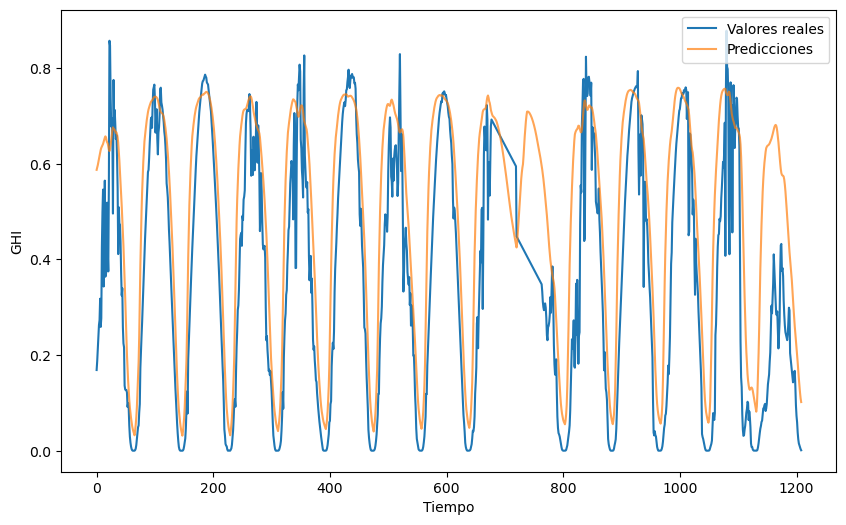

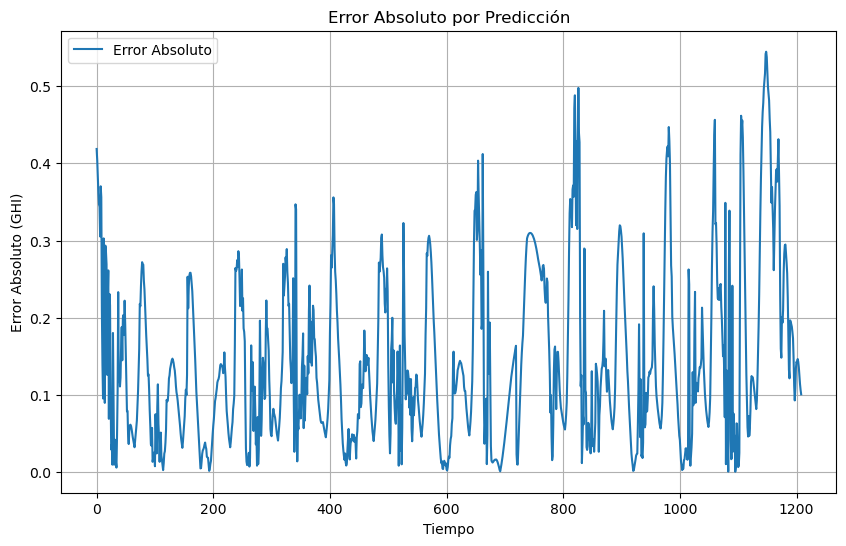

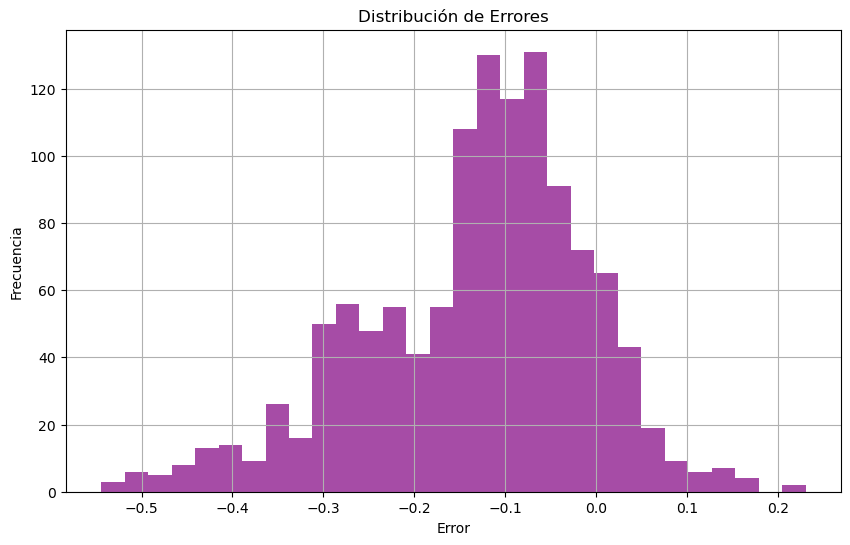

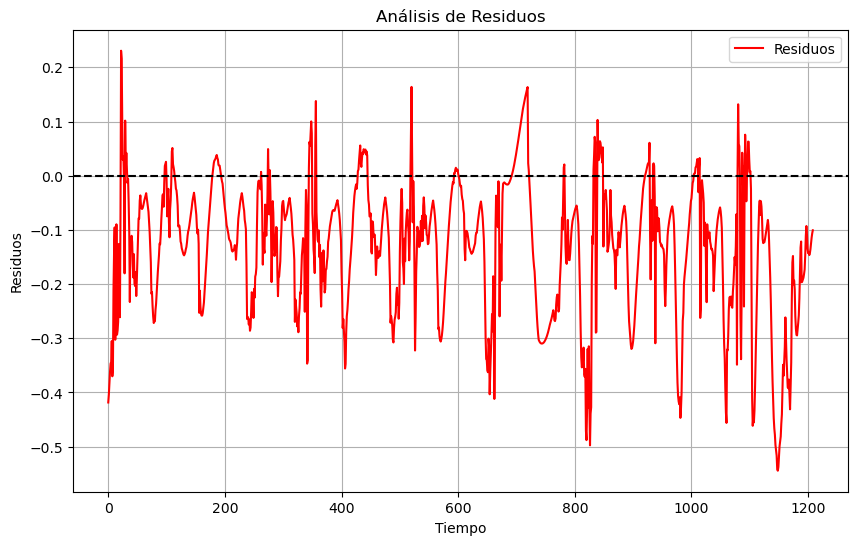

In [19]:
# Probar el modelo
# Preparar el conjunto de prueba (días nubosos)
fecha_inicio_prueba = '2023-05-1 05:00:00'  # Fecha de inicio de prueba
fecha_fin_prueba = '2023-05-15 18:00:00'  # Fecha de fin de prueba

# Filtrar el DataFrame por el rango de prueba
df_prueba = df[(df['Timestamp'] >= fecha_inicio_prueba) & (df['Timestamp'] <= fecha_fin_prueba)]

# Cargar imágenes y valores GHI para el conjunto de prueba
X_images_test, y_ghi_test, scaler_test, doy_sin_test, doy_cos_test, hour_sin_train,hour_cos_train, fourier_features_train = load_images_and_ghi(df_prueba, image_folder)

# Concatenar DOY sin y cos con las imágenes de prueba
X_aux_features_test = np.concatenate([doy_sin_test, doy_cos_test,hour_sin_train,hour_cos_train,fourier_features_train], axis=1)

# Crear las secuencias de prueba con time_steps 
X_images_test_seq, X_aux_test_seq, y_test_seq = create_sequences(X_images_test, X_aux_features_test, y_ghi_test, time_steps)

# Hacer predicciones
y_pred = model.predict([X_images_test_seq, X_aux_test_seq])

# Invertir la normalización para GHI
y_test_seq_inversed = scaler_test.inverse_transform(y_test_seq)
y_pred_inversed = scaler_test.inverse_transform(y_pred)

# Evaluar el modelo
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test_seq_inversed, y_pred_inversed)
rmse = np.sqrt(mean_squared_error(y_test_seq_inversed, y_pred_inversed))

print(f'MAE en el conjunto de prueba: {mae}')
print(f'RMSE en el conjunto de prueba: {rmse}')

# Visualizar algunas predicciones
plt.figure(figsize=(10, 6))
plt.plot(y_test_seq_inversed, label='Valores reales')
plt.plot(y_pred_inversed, label='Predicciones', alpha=0.7)
plt.xlabel('Tiempo')
plt.ylabel('GHI')
plt.legend()
plt.show()

error_absoluto = np.abs(y_test_seq_inversed - y_pred_inversed)
plt.figure(figsize=(10, 6))
plt.plot(error_absoluto, label='Error Absoluto')
plt.xlabel('Tiempo')
plt.ylabel('Error Absoluto (GHI)')
plt.title('Error Absoluto por Predicción')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(y_test_seq_inversed - y_pred_inversed, bins=30, alpha=0.7, color='purple')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.title('Distribución de Errores')
plt.grid()
plt.show()

residuos = y_test_seq_inversed - y_pred_inversed
plt.figure(figsize=(10, 6))
plt.plot(residuos, label='Residuos', color='red')
plt.xlabel('Tiempo')
plt.ylabel('Residuos')
plt.title('Análisis de Residuos')
plt.axhline(y=0, color='black', linestyle='--')
plt.legend()
plt.grid()
plt.show()

In [20]:
import optuna.visualization as vis

# Graficar el historial de optimización
fig_optimization_history = vis.plot_optimization_history(study)
fig_optimization_history.show()

In [21]:
# Graficar la importancia de cada hiperparámetro
fig_param_importances = vis.plot_param_importances(study)
fig_param_importances.show()


In [22]:
# Graficar las coordenadas paralelas para ver las interacciones entre hiperparámetros
fig_parallel_coordinate = vis.plot_parallel_coordinate(study)
fig_parallel_coordinate.show()